# **Predicting Survival of Patient**

## **@Author :- Priyangshu Sarkar**

## **Import Libraries**

In [2]:
!pip install -q shap

     |████████████████████████████████| 564 kB 5.3 MB/s 


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix)

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import shap

pd.set_option('display.max_rows', 250)

## **Importing Data**

In [5]:
df=pd.read_csv("Dataset_Patient.csv")

In [6]:
df

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.730000,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.420000,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.950000,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.640000,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45820,90508,19814,21,0,86.0,24.136910,0,Hispanic,M,167.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
45821,64010,80420,21,0,55.0,27.913563,1,Caucasian,F,162.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
45822,101166,124288,21,0,59.0,42.581313,0,Caucasian,M,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
45823,27015,41654,21,0,54.0,42.850872,0,Caucasian,M,180.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal


## **Exploratory Data Analysis (EDA)**

In [7]:
df.shape

(45825, 186)

In [8]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45825 entries, 0 to 45824
Data columns (total 186 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    encounter_id                   45825 non-null  int64  
 1    patient_id                     45825 non-null  int64  
 2    hospital_id                    45825 non-null  int64  
 3    hospital_death                 45825 non-null  int64  
 4    age                            43665 non-null  float64
 5    bmi                            43356 non-null  float64
 6    elective_surgery               45825 non-null  int64  
 7    ethnicity                      45434 non-null  object 
 8    gender                         45806 non-null  object 
 9    height                         45244 non-null  float64
 10   hospital_admit_source          38871 non-null  object 
 11   icu_admit_source               45747 non-null  object 
 12   icu_id                        

In [9]:
df.describe()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,45825.000000,45825.000000,45825.000000,45825.000000,43665.000000,43356.000000,45825.000000,45244.000000,45824.000000,45824.000000,...,40964.000000,40964.000000,45421.000000,45421.000000,45421.000000,45421.000000,45421.000000,45421.000000,45421.000000,45421.000000
mean,65625.932875,65557.129624,106.995985,0.086219,62.651804,29.167440,0.211740,169.430737,319.255783,0.915524,...,0.087317,0.047765,0.000859,0.017855,0.219062,0.014839,0.028665,0.007089,0.003787,0.021268
std,37774.188036,37832.562156,49.579404,0.280691,16.610883,8.267124,0.408546,10.785900,139.640291,2.719805,...,0.261706,0.225731,0.029290,0.132426,0.413615,0.120909,0.166865,0.083900,0.061421,0.144277
min,1.000000,1.000000,4.000000,0.000000,16.000000,14.844926,0.000000,137.200000,82.000000,-24.947222,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32982.000000,32731.000000,70.000000,0.000000,53.000000,23.646750,0.000000,162.200000,185.000000,0.027083,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,65562.000000,65478.000000,112.000000,0.000000,65.000000,27.595103,0.000000,170.000000,369.000000,0.118056,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,98544.000000,98330.000000,147.000000,0.000000,75.000000,32.891428,0.000000,177.800000,431.000000,0.465972,...,0.130000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,131051.000000,131043.000000,204.000000,1.000000,89.000000,67.814990,1.000000,195.590000,514.000000,159.090972,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
df.isnull().sum(axis=0).sort_values(ascending=False)


h1_bilirubin_min                 42374
h1_bilirubin_max                 42374
h1_albumin_min                   42154
h1_albumin_max                   42154
h1_lactate_min                   41831
h1_lactate_max                   41831
h1_pao2fio2ratio_min             39262
h1_pao2fio2ratio_max             39262
h1_calcium_max                   37676
h1_calcium_min                   37676
h1_hco3_max                      37376
h1_hco3_min                      37376
h1_platelets_min                 37315
h1_platelets_max                 37315
h1_bun_min                       37232
h1_bun_max                       37232
h1_wbc_max                       37201
h1_wbc_min                       37201
h1_creatinine_min                37200
h1_creatinine_max                37200
h1_arterial_po2_max              36921
h1_arterial_po2_min              36921
h1_arterial_pco2_max             36912
h1_arterial_pco2_min             36912
h1_arterial_ph_max               36889
h1_arterial_ph_min       

columns that can be dropped: **'encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'**

Notice the amount of missing values in each row
We decide a threshold value to delete some of the attributes from the dataset (25k in this approach)
**74 columns** will get deleted in this turn.

In [11]:
print("Number of rows with missing values:", df.isnull().any(axis=1).sum())

Number of rows with missing values: 45803


In [12]:
large_missing = df.isnull().sum(axis=0).sort_values(ascending=False)[df.isnull().sum(axis=0).sort_values(ascending=False) > 25000]

print("\nTotal features with more than", 25000, "missing values:", len(large_missing))

df.drop(large_missing.index.tolist() + ['encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'], 
              axis=1,
             inplace = True)
df


Total features with more than 25000 missing values: 71


,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,0,19.0,NaN,0,Caucasian,M,188.0,Med-Surg ICU,0.073611,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45820,0,86.0,24.136910,0,Hispanic,M,167.6,CCU-CTICU,0.835417,67.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
45821,0,55.0,27.913563,1,Caucasian,F,162.6,SICU,4.018750,73.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
45822,0,59.0,42.581313,0,Caucasian,M,172.7,MICU,0.060417,127.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
45823,0,54.0,42.850872,0,Caucasian,M,180.3,Med-Surg ICU,-0.008333,139.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Gastrointestinal,Gastrointestinal


In [13]:
df.nunique()

hospital_death                       2
age                                 74
bmi                              23169
elective_surgery                     2
ethnicity                            6
gender                               2
height                             352
icu_type                             8
pre_icu_los_days                  7181
weight                            2566
apache_2_diagnosis                  44
apache_3j_diagnosis                387
apache_post_operative                2
arf_apache                           2
bun_apache                         127
creatinine_apache                 1037
gcs_eyes_apache                      4
gcs_motor_apache                     6
gcs_unable_apache                    2
gcs_verbal_apache                    5
glucose_apache                     548
heart_rate_apache                  149
hematocrit_apache                  353
intubated_apache                     2
map_apache                         161
resprate_apache          

*Removing missing values from some of the inter-related columns (bmi, weight and height)*

*We cut down almost 3000 instances with this process safely*

In [14]:
df = df[df[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
df

,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,icu_type,pre_icu_los_days,weight,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,0,68.0,22.730000,0,Caucasian,M,180.3,CTICU,0.541667,73.9,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,0,77.0,27.420000,0,Caucasian,F,160.0,Med-Surg ICU,0.927778,70.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,0,25.0,31.950000,0,Caucasian,F,172.7,Med-Surg ICU,0.000694,95.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,0,81.0,22.640000,1,Caucasian,F,165.1,CTICU,0.000694,61.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
5,0,67.0,27.560000,0,Caucasian,M,190.5,Med-Surg ICU,0.000694,100.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Neurological,Neurologic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45819,0,87.0,35.133404,0,Caucasian,F,152.4,MICU,0.102083,81.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
45820,0,86.0,24.136910,0,Hispanic,M,167.6,CCU-CTICU,0.835417,67.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
45821,0,55.0,27.913563,1,Caucasian,F,162.6,SICU,4.018750,73.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
45822,0,59.0,42.581313,0,Caucasian,M,172.7,MICU,0.060417,127.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular


## **Univariate-Multivariate Analysis**
Individual plots seldom doesn't help in large datasets, in this approach let's look at the variation of instances according to each context of the column



The death rate for Male-Female patients is shown below. While the rate of **female deaths** are higher the youngest person to pass away during one of the case was a **Male** of **16yrs** of age

In [15]:
fig = px.histogram(df[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=df[['age','gender','hospital_death','bmi']].columns)
fig.show()

## **Average hospital death probability of patients**

*based on age and gender*

In [16]:
age_death_F=df[df['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=df[df['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()
from plotly.subplots import make_subplots
fig = make_subplots()
fig.add_trace(
    go.Scatter(x=age_death_F['age'], y=age_death_F['hospital_death'], name="Female patients"))
fig.add_trace(
    go.Scatter(x=age_death_M['age'], y=age_death_M['hospital_death'],name="Male patients"))
fig.update_layout(
    title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

## **impacts of BMI and weight over patients**

In [17]:
weight_df=df[['weight','hospital_death','bmi']]
weight_df['weight']=weight_df['weight'].round(0)
weight_df['bmi']=weight_df['bmi'].round(0)
weight_death=weight_df[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death=weight_df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(
    go.Scatter(x=weight_death['weight'], y=weight_death['hospital_death'], name="Weight"),
   row=1, col=1
)
fig.add_trace(
    go.Scatter(x=bmi_death['bmi'], y=bmi_death['hospital_death'], name="BMI"),
    row=1, col=2
)
fig.update_layout(
    title_text="<b>impacts of BMI and weight over patients<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death")
fig.show()

## **Survival rate at different types of ICU**

*some of the ICU wards have higher death probability pertaining to being surgical wards*

In [18]:
ICU_type=df[['icu_type','age','hospital_death']]
ICU_type['icu_type']=ICU_type['icu_type'].replace({'CTICU':'CCU-CTICU',
                                              'Cardiac ICU':'CCT-CTICU',
                                              'CTICU':'CCT-CTICU',
                                              'CSICU':'SICU'})
#ICU_type['pre_icu_los_days']=ICU_type['pre_icu_los_days'].round(0)
ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.scatter(ICU_df, x="age", y="hospital_death", size="count", color="icu_type",
           hover_name="icu_type", log_x=False, size_max=60,)
fig.update_layout(
    title_text="<b>Survival rate at different types of ICU<b>"
)
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

## **Hospital Death Rate, by age and Medical condition**

In [19]:
apache3=df[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems =list(apache3['apache_3j_bodysystem'].unique())
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s),
                 method = 'update',
                 args = [{'visible': visible},
                         {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,     
        x = apache3.loc[mask, 'age'],
        y = apache3.loc[mask, 'mean'],
        mode = 'markers',
        marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000,
                 'color':apache3.loc[mask, 'mean'],
                 'showscale': True})
                   )
    data.append(trace)

data[0]['visible'] = True    
    
layout = dict(updatemenus=list([dict(buttons= list_updatemenus)]),
              xaxis=dict(title = '<b>Age<b>', range=[min(apache3.loc[:, 'age'])-10, max(apache3.loc[:, 'age']) + 10]),
              yaxis=dict(title = '<b>Average Hospital Death<b>', range=[min(apache3.loc[:, 'mean'])-0.1, max(apache3.loc[:, 'mean'])+0.1]),
              title='<b>Survival Rate<b>' )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

##**Density Distribution for numerical columns**

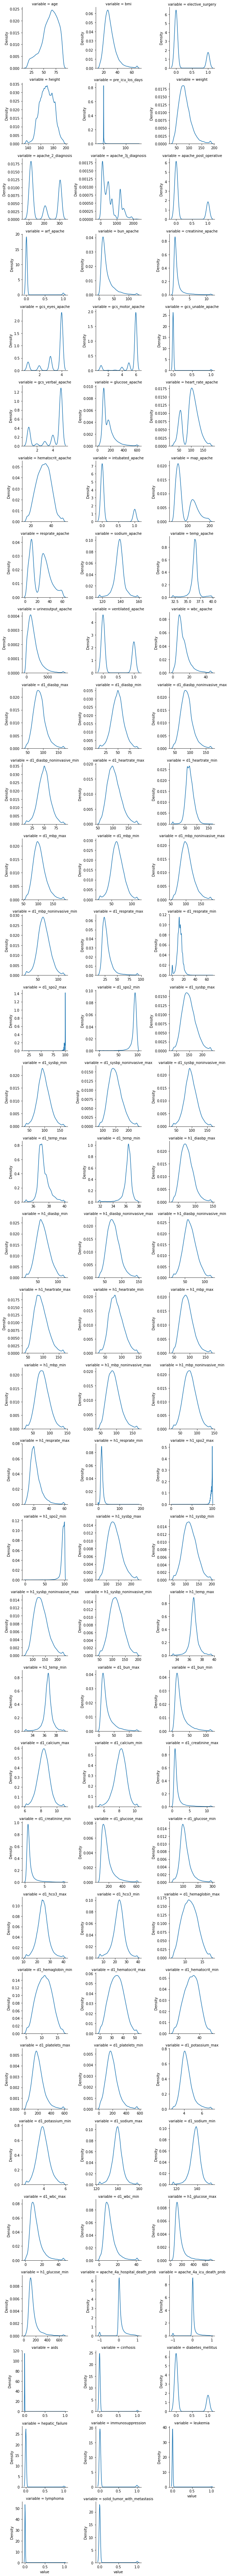

In [20]:
unpivot = pd.melt(df, df.describe().columns[0], df.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

## **Preprocessing**
converting categorical values
tranforming numerical columns and removing nulls

Null values for categories are replaced by **mode**, and those for numerical are replaced by **mean**.

In [21]:
numerical_cat = [
 'elective_surgery',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

categorical = ['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [22]:
df.nunique()[df.nunique() == 2].index.tolist()

['hospital_death',
 'elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [23]:
df.select_dtypes(include='O').columns.values.tolist()

['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [24]:
not_numeric = df[numerical_cat + categorical + ['hospital_death']].columns.tolist()
numeric_only = df.drop(not_numeric,axis=1).columns.tolist()
numeric_only

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_no

In [25]:
for col in numerical_cat:
  df[col] = df[col].astype('Int64')
    
for col in numerical_cat:
    df[col] = df[col].fillna(df[col].mode()[0])

In [26]:
df[numeric_only].isna().sum(axis=0).sort_values(ascending=False)

h1_glucose_min                   21686
h1_glucose_max                   21686
urineoutput_apache               19517
wbc_apache                        9812
bun_apache                        8887
hematocrit_apache                 8839
creatinine_apache                 8572
sodium_apache                     8518
h1_temp_max                       7057
h1_temp_min                       7057
d1_platelets_min                  6436
d1_platelets_max                  6436
d1_wbc_max                        6077
d1_wbc_min                        6077
d1_hemaglobin_min                 5800
d1_hemaglobin_max                 5800
d1_calcium_max                    5717
d1_calcium_min                    5717
d1_hco3_max                       5575
d1_hco3_min                       5575
d1_hematocrit_max                 5335
d1_hematocrit_min                 5335
d1_bun_max                        5134
d1_bun_min                        5134
h1_mbp_noninvasive_min            5044
h1_mbp_noninvasive_max   

In [27]:
split_one = df[numeric_only].isna().sum(axis=0).sort_values()[df[numeric_only].isna().sum(axis=0) < 11000].index.tolist()
split_two = df[numeric_only].isna().sum(axis=0).sort_values()[df[numeric_only].isna().sum(axis=0) > 11000].index.tolist()

In [28]:
split_two

['urineoutput_apache', 'h1_glucose_max', 'h1_glucose_min']

In [29]:
for col in split_two:
    df[col] = df[col].fillna(df[col].mean())

process_data = df.dropna(axis=0)

In [30]:
process_data[categorical].nunique()

ethnicity                6
gender                   2
icu_type                 8
apache_3j_bodysystem    11
apache_2_bodysystem     10
dtype: int64

In [31]:
icu_data = pd.get_dummies(process_data,
    prefix='isin',
    prefix_sep='_',
    columns=categorical,
    drop_first=False)
icu_data.reset_index(drop = True, inplace = True)
icu_data

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,...,isin_Cardiovascular,isin_Gastrointestinal,isin_Haematologic,isin_Metabolic,isin_Neurologic,isin_Renal/Genitourinary,isin_Respiratory,isin_Trauma,isin_Undefined Diagnoses,isin_Undefined diagnoses
0,0,68.0,22.730000,0,180.30,0.541667,73.9,113.0,502.01,0,...,1,0,0,0,0,0,0,0,0,0
1,0,77.0,27.420000,0,160.00,0.927778,70.2,108.0,203.01,0,...,0,0,0,0,0,0,1,0,0,0
2,0,67.0,27.560000,0,190.50,0.000694,100.0,301.0,403.01,0,...,0,0,0,0,1,0,0,0,0,0
3,0,46.0,25.845717,0,167.60,0.000000,72.6,108.0,203.01,0,...,0,0,0,0,0,0,1,0,0,0
4,0,87.0,21.963763,0,180.30,5.046528,71.4,113.0,501.05,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18771,0,74.0,26.096991,0,177.80,0.115278,82.5,114.0,102.01,0,...,1,0,0,0,0,0,0,0,0,0
18772,0,79.0,23.159226,0,162.56,0.059028,61.2,110.0,104.01,0,...,1,0,0,0,0,0,0,0,0,0
18773,0,85.0,18.943655,0,172.70,0.083333,56.5,108.0,203.01,0,...,0,0,0,0,0,0,1,0,0,0
18774,0,71.0,23.250046,0,177.80,0.195833,73.5,301.0,403.01,0,...,0,0,0,0,1,0,0,0,0,0


In [32]:
icu_data.columns = [x.lower() for x in icu_data.columns.tolist()]
icu_data = icu_data.loc[:,~icu_data.columns.duplicated()]

In [33]:
t = icu_data['arf_apache'].dtype
for col in tqdm(icu_data.columns.tolist()):
    if icu_data[col].values.dtype == 'uint8' or t == icu_data[col].values.dtype:
        icu_data[col] = icu_data[col].astype(int)

100%|██████████| 133/133 [00:00<00:00, 4166.11it/s]


In [34]:
icu_data.dtypes

hospital_death                     int64
age                              float64
bmi                              float64
elective_surgery                   int64
height                           float64
pre_icu_los_days                 float64
weight                           float64
apache_2_diagnosis               float64
apache_3j_diagnosis              float64
apache_post_operative              int64
arf_apache                         int64
bun_apache                       float64
creatinine_apache                float64
gcs_eyes_apache                  float64
gcs_motor_apache                 float64
gcs_unable_apache                  int64
gcs_verbal_apache                float64
glucose_apache                   float64
heart_rate_apache                float64
hematocrit_apache                float64
intubated_apache                   int64
map_apache                       float64
resprate_apache                  float64
sodium_apache                    float64
temp_apache     

## **Modelling**

In [35]:
X = icu_data.drop(['hospital_death'], axis=1)
y = icu_data['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=11, 
                                                    stratify = y)

In [36]:
icu_data.to_csv('/content/Dataset_Patient.csv', index=False)
X_test.to_csv("/content/Dataset_Patient.csv", index=False)

In [37]:
y_train.value_counts()

0    11922
1     1221
Name: hospital_death, dtype: int64

In [38]:
y_test.value_counts()

0    5110
1     523
Name: hospital_death, dtype: int64

In [39]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
#         scores['xgb']['roc_auc'] = roc_auc_score(y_test, y_pred)

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
#         scores['rf']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
#         scores['extree']['roc_auc'] = roc_auc_score(y_test, y_pred)
        models.append(extree)
        
    return scores

In [ ]:
modelling(X_train,y_train, X_test, y_test, xgb=True, rf=True, extree=True)

{'extree': [0.9227303446722235, 0.6084453975078975],
 'rf': [0.9249831043027709, 0.6350888225888226],
 'xgb': [0.9247578283397162, 0.6482187341562342]}

In [40]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_hat) , 3)
    fpr, tpr, t = roc_curve(y_test, y_hat)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
        #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                          specs=[ 
#                               [{'colspan': 2}, None],
                                 [{}, {}],
                                 [{}, {}],
                                 
#                                  [{'colspan': 2}, None]
                                ],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
    fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
    fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
    fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

## **Parameter Tuning**

In [41]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

fit_params_of_xgb = {
    "early_stopping_rounds":100, 
    "eval_metric" : 'auc', 
    "eval_set" : [(X_test, y_test)],
    'verbose': 100,
}


# A parameter grid for XGBoost
params = {
    'booster': ["gbtree"],
    'learning_rate': [0.1],
    'n_estimators': range(100, 500, 100),
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'max_depth': [5],
    "scale_pos_weight": [1]
}

xgb_estimator = XGBClassifier(
    objective='binary:logistic',
    # silent=True,
)

gsearch = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=gkf
)

xgb_model = gsearch.fit(X=X_train, y=y_train, **fit_params_of_xgb)
(gsearch.best_params_, gsearch.best_score_)

[0]	validation_0-auc:0.83852
Will train until validation_0-auc hasn't improved in 100 rounds.
[99]	validation_0-auc:0.87816


({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 100,
  'scale_pos_weight': 1,
  'subsample': 0.8},
 0.8858625233389263)

## **Final Model Evaluation**


In [42]:
xgb_tuned = XGBClassifier(n_estimators=3000,
    objective='binary:logistic',
    booster="gbtree",
    learning_rate=0.01,
    scale_pos_weight=1,
    max_depth=4,
    min_child_weight=6,
    gamma=0,
    subsample=0.4,
    colsample_bytree=0.8,
    reg_alpha=0.08,
    n_jobs=-1)

xgb_tuned.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
y__hat = xgb_tuned.predict(X_test._get_numeric_data())

In [43]:
joblib.dump(xgb_tuned, 'model.sav')

['model.sav']

In [44]:
y__hat[21:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [55]:
desc = pd.read_csv("/content/Data Dictionary_Patient.csv")
feats_ = ['apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob', 'age', 'd1_spo2_min',
'd1_resprate_max', 'd1_heartrate_min', 'd1_temp_max', 'ventilated_apache', 'd1_bun_min',
'apache_3j_diagnosis', 'bmi']

desc[desc["Variable Name"].isin(feats_)][['Variable Name', 'Description']]

,Variable Name,Description
4,age,The age of the patient on unit admission
5,bmi,The body mass index of the person on unit admi...
21,apache_3j_diagnosis,The APACHE III-J sub-diagnosis code which best...
45,ventilated_apache,Whether the patient was invasively ventilated ...
54,d1_heartrate_min,The patient's lowest heart rate during the fir...
61,d1_resprate_max,The patient's highest respiratory rate during ...
64,d1_spo2_min,The patient's lowest peripheral oxygen saturat...
71,d1_temp_max,The patient's highest core temperature during ...
104,d1_bun_min,The lowest blood urea nitrogen concentration o...
175,apache_4a_hospital_death_prob,The APACHE IVa probabilistic prediction of in-...


In [47]:
df.isnull().sum()

hospital_death                      0
age                              2045
bmi                                 0
elective_surgery                    0
ethnicity                         321
gender                             14
height                              0
icu_type                            0
pre_icu_los_days                    0
weight                              0
apache_2_diagnosis                848
apache_3j_diagnosis               566
apache_post_operative               0
arf_apache                          0
bun_apache                       8887
creatinine_apache                8572
gcs_eyes_apache                  1218
gcs_motor_apache                 1218
gcs_unable_apache                   0
gcs_verbal_apache                1218
glucose_apache                   4482
heart_rate_apache                 459
hematocrit_apache                8839
intubated_apache                    0
map_apache                        546
resprate_apache                   524
sodium_apach

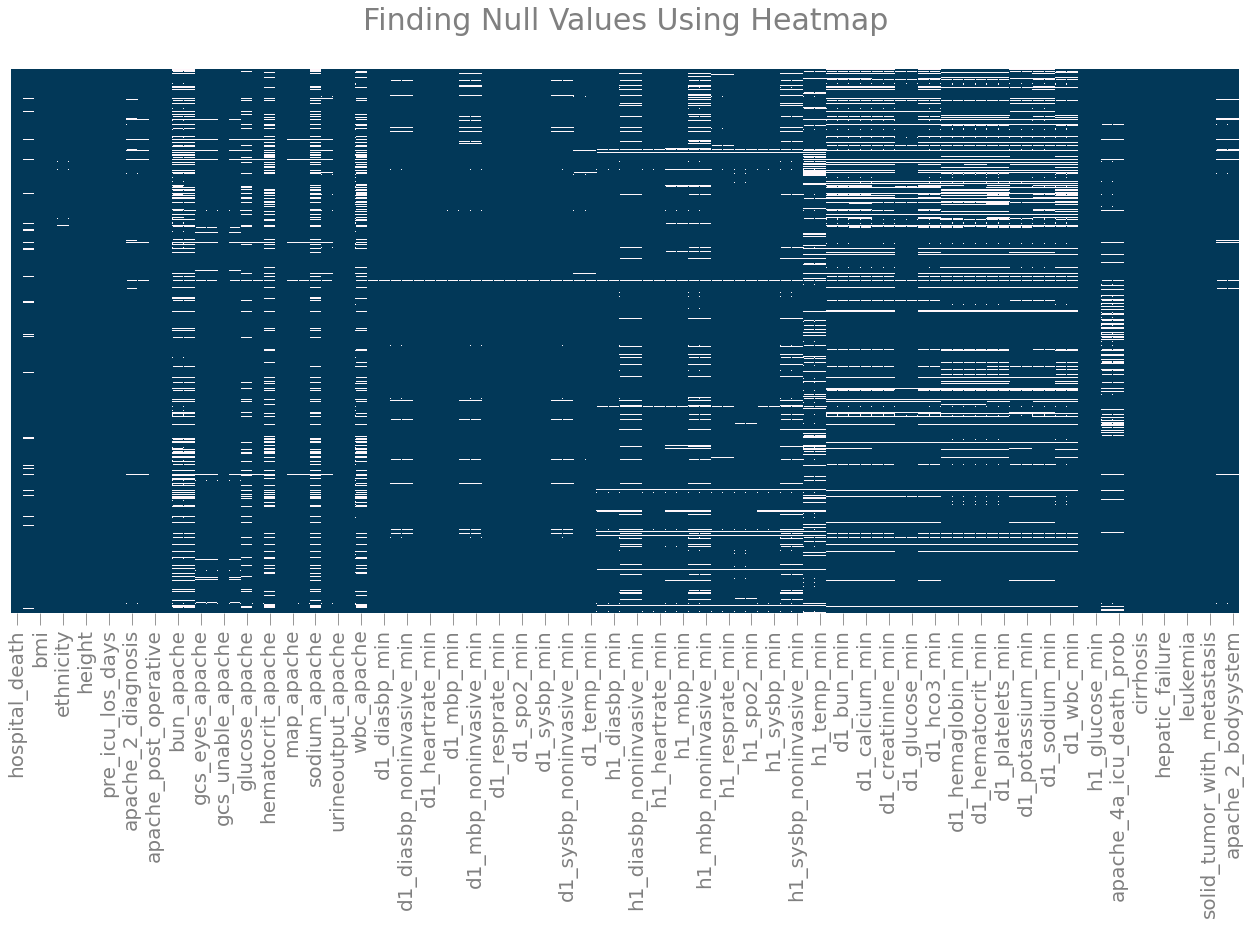

In [49]:
plt.figure(figsize=(22, 10))
plt.xticks(size=20, color='grey')
plt.tick_params(size=12, color='grey')
plt.title('Finding Null Values Using Heatmap\n', color='grey', size=30)
sns.heatmap(df.isnull(),
            yticklabels=False,
            cbar=False,
            cmap='PuBu_r',
            )

In [50]:
df.describe()

,hospital_death,age,bmi,elective_surgery,height,pre_icu_los_days,weight,apache_2_diagnosis,apache_3j_diagnosis,apache_post_operative,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
count,43355.000000,41310.000000,43355.000000,43355.000000,43355.000000,43355.000000,43355.000000,42507.000000,42789.000000,43355.000000,...,38781.000000,38781.000000,43355.000000,43355.000000,43355.000000,43355.000000,43355.000000,43355.000000,43355.000000,43355.000000
mean,0.086218,62.708182,29.167591,0.212617,169.431103,0.919850,83.749894,187.996918,580.829280,0.231369,...,0.089773,0.049831,0.000853,0.017760,0.216423,0.014785,0.027955,0.007173,0.003852,0.020874
std,0.280690,16.578398,8.267159,0.409163,10.783420,2.734034,24.950710,85.948333,476.318737,0.421713,...,0.259672,0.223202,0.029201,0.132081,0.411810,0.120692,0.164847,0.084392,0.061945,0.142965
min,0.000000,16.000000,14.844926,0.000000,137.200000,-24.947222,38.600000,101.000000,0.010000,0.000000,...,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,53.000000,23.646750,0.000000,162.000000,0.031944,66.500000,113.000000,204.010000,0.000000,...,0.020000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,65.000000,27.595103,0.000000,170.000000,0.122222,80.000000,123.000000,410.010000,0.000000,...,0.050000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,75.000000,32.892230,0.000000,177.800000,0.472222,96.700000,302.000000,901.030000,0.000000,...,0.140000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,89.000000,67.814990,1.000000,195.590000,159.090972,186.000000,308.000000,2201.050000,1.000000,...,0.990000,0.970000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


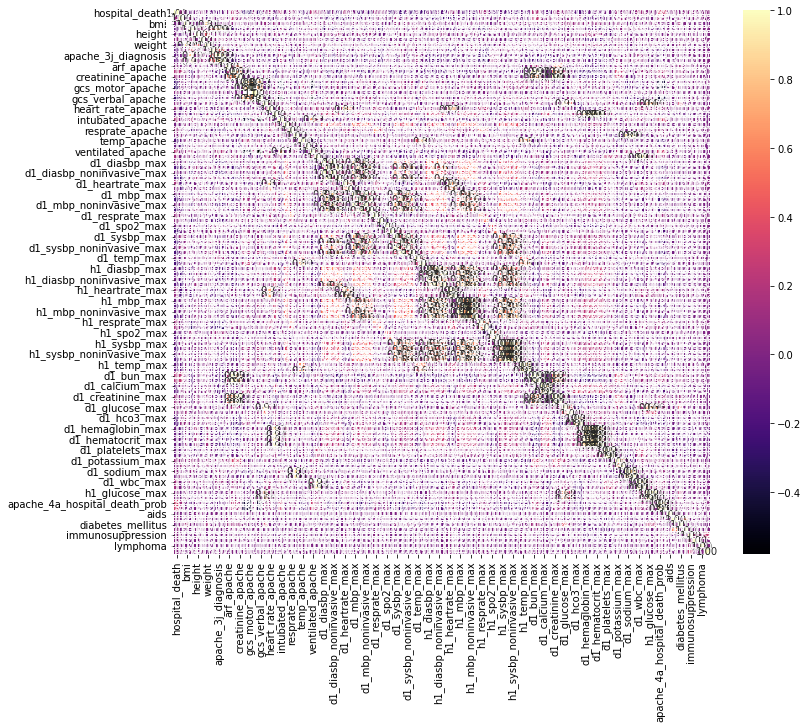

In [53]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap="magma", fmt='.2f')

### **1. What is the probability of a patient's survival after diagnosis?**

The Survival of the patient is largely dependent upon the hospital      reputaion and the icu ward where the patient is kept



### **2. What should be taken care of?**

There is a codependency of the death rate and cardiovascular health of the patient



### **3. What is the scope of this project?**

This project can serve as a hospital esteem stature. With more accurate data and better modelling procedure

